In [30]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.problems.many.wfg import WFG1
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
from scipy.spatial.distance import cdist
from collections import Counter
from scipy.linalg import LinAlgError

In [31]:
def factorial(n):
    return 1 if n in (0, 1) else n * factorial(n - 1)

def combinacion(n, m):
    if m == 0 or m == n:
        return 1
    elif m > n:
        return 0
    else:
        return factorial(n) // (factorial(m) * factorial(n - m))

In [32]:
# generación de puntos de referencia Das & Dennis
def puntos_ref(npop, nvar):
    h1 = 0
    while combinacion(h1 + nvar, nvar - 1) <= npop:
        h1 += 1
    puntos = np.array(list(combinations(np.arange(1, h1 + nvar), nvar - 1))) - np.arange(nvar - 1) - 1
    puntos = (np.concatenate((puntos, np.zeros((puntos.shape[0], 1)) + h1), axis=1) -
              np.concatenate((np.zeros((puntos.shape[0], 1)), puntos), axis=1)) / h1
    if h1 < nvar:
        h2 = 0
        while combinacion(h1 + nvar - 1, nvar - 1) + combinacion(h2 + nvar, nvar - 1) <= npop:
            h2 += 1
        if h2 > 0:
            t_puntos = np.array(list(combinations(np.arange(1, h2 + nvar), nvar - 1))) - np.arange(nvar - 1) - 1
            t_puntos = (np.concatenate((t_puntos, np.zeros((t_puntos.shape[0], 1)) + h2), axis=1) -
                           np.concatenate((np.zeros((t_puntos.shape[0], 1)), t_puntos), axis=1)) / h2
            t_puntos = t_puntos / 2 + 1 / (2 * nvar)
            puntos = np.concatenate((puntos, t_puntos), axis=0)
    return puntos

In [33]:
# normalización de los puntos de referencia
def normal(F, front0_indices):
    z_min = F.min(axis=0)
    z_max = F[front0_indices].max(axis=0)
    return (F - z_min) / (z_max - z_min + 1e-12)

In [34]:
#  Fast Non-Dominated Sorting fnds
def nd_sort(objs):
    (npop, nobj) = objs.shape
    n = np.zeros(npop, dtype=int)
    s = []
    rank = np.zeros(npop, dtype=int)
    ind = 0
    pfs = {ind: []}
    
    for i in range(npop):
        s.append([])
        for j in range(npop):
            if i != j:
                less = equal = more = 0
                for k in range(nobj):
                    if objs[i, k] < objs[j, k]:
                        less += 1
                    elif objs[i, k] == objs[j, k]:
                        equal += 1
                    else:
                        more += 1
                if less == 0 and equal != nobj:
                    n[i] += 1
                elif more == 0 and equal != nobj:
                    s[i].append(j)
        if n[i] == 0:
            pfs[ind].append(i)
            rank[i] = ind

    while pfs[ind]:
        pfs[ind + 1] = []
        for i in pfs[ind]:
            for j in s[i]:
                n[j] -= 1
                if n[j] == 0:
                    pfs[ind + 1].append(j)
                    rank[j] = ind + 1
        ind += 1

    pfs.pop(ind)
    return pfs, rank

In [35]:
# selección de nicho
def nicho(F_norm, ref_dirs, front_indices, N_remaining):

    F_partial = F_norm[front_indices]

    cos = 1 - cdist(F_partial, ref_dirs, metric='cosine') 
    norm = np.linalg.norm(F_partial, axis=1).reshape(-1, 1)
    distancia = norm * np.sqrt(1 - cos ** 2)  

    a_refs = np.argmin(distancia, axis=1)
    a_distancias = np.min(distancia, axis=1)

    ncc = np.zeros(ref_dirs.shape[0], dtype=int)
    for ref in a_refs:
        ncc[ref] += 1

    sflags = np.full(len(F_partial), False)
    ref_flags = np.full(len(ref_dirs), True)  
    sel_index = []

    while len(sel_index) < N_remaining:
        candidato_refs = np.where(ref_flags)[0]
        min_count = np.min(ncc[candidato_refs])
        candidatos = candidato_refs[ncc[candidato_refs] == min_count]
        chosen_ref = np.random.choice(candidatos)

        sol_idxs = np.where((a_refs == chosen_ref) & (~sflags))[0]
        if sol_idxs.size > 0:
            best = sol_idxs[np.argmin(a_distancias[sol_idxs])]
            sflags[best] = True
            sel_index.append(front_indices[best])
            ncc[chosen_ref] += 1
        else:
            ref_flags[chosen_ref] = False

    return sel_index

In [36]:
# selección de la población
def selection(pop, pc, rank, k=2):
    (npop, nvar) = pop.shape
    nm = int(npop * pc)
    nm = nm if nm % 2 == 0 else nm + 1
    sub_pop = np.zeros((nm, nvar))
    for i in range(nm):
        [ind1, ind2] = np.random.choice(npop, k, replace=False)
        if rank[ind1] <= rank[ind2]:
            sub_pop[i] = pop[ind1]
        else:
            sub_pop[i] = pop[ind2]
    return sub_pop

In [37]:
# función de cruza SBX
def cruza(sub_pop, lb, ub, pc, eta_c):
    # simulated binary crossover (SBX)
    (noff, nvar) = sub_pop.shape
    nm = int(noff / 2)
    padre1 = sub_pop[:nm]
    padre2 = sub_pop[nm:]
    beta = np.zeros((nm, nvar))
    mu = np.random.random((nm, nvar))
    flag1 = mu <= 0.5
    flag2 = ~flag1
    beta[flag1] = (2 * mu[flag1]) ** (1 / (eta_c + 1))
    beta[flag2] = (2 - 2 * mu[flag2]) ** (-1 / (eta_c + 1))
    beta = beta * (-1) ** np.random.randint(0, 2, (nm, nvar))
    beta[np.random.random((nm, nvar)) < 0.5] = 1
    beta[np.tile(np.random.random((nm, 1)) > pc, (1, nvar))] = 1
    hijos1 = (padre1 + padre2) / 2 + beta * (padre1 - padre2) / 2
    hijos2 = (padre1 + padre2) / 2 - beta * (padre1 - padre2) / 2
    hijos = np.concatenate((hijos1, hijos2), axis=0)
    hijos = np.min((hijos, np.tile(ub, (noff, 1))), axis=0)
    hijos = np.max((hijos, np.tile(lb, (noff, 1))), axis=0)
    return hijos

In [38]:
# función de mutación
def muta(pop, lb, ub, pm, eta_m):
    # polynomial mutation
    (npop, nvar) = pop.shape
    lb = np.tile(lb, (npop, 1))
    ub = np.tile(ub, (npop, 1))
    site = np.random.random((npop, nvar)) < pm / nvar
    mu = np.random.random((npop, nvar))
    delta1 = (pop - lb) / (ub - lb)
    delta2 = (ub - pop) / (ub - lb)
    temp = np.logical_and(site, mu <= 0.5)
    pop[temp] += (ub[temp] - lb[temp]) * ((2 * mu[temp] + (1 - 2 * mu[temp]) * (1 - delta1[temp]) ** (eta_m + 1)) ** (1 / (eta_m + 1)) - 1)
    temp = np.logical_and(site, mu > 0.5)
    pop[temp] += (ub[temp] - lb[temp]) * (1 - (2 * (1 - mu[temp]) + 2 * (mu[temp] - 0.5) * (1 - delta2[temp]) ** (eta_m + 1)) ** (1 / (eta_m + 1)))
    pop = np.min((pop, ub), axis=0)
    pop = np.max((pop, lb), axis=0)
    return pop

In [39]:
# función de selección del ambiente
def env_sel(pop, objs, zmin, npop, V):
    pfs, rank = nd_sort(objs)
    nobj = objs.shape[1]
    selected = np.full(pop.shape[0], False)
    ind = 0
    while np.sum(selected) + len(pfs[ind]) <= npop:
        selected[pfs[ind]] = True
        ind += 1
    K = npop - np.sum(selected)
    
    objs1 = objs[selected]
    objs2 = objs[pfs[ind]]
    npop1 = objs1.shape[0]
    npop2 = objs2.shape[0]
    nv = V.shape[0]
    temp_objs = np.concatenate((objs1, objs2), axis=0)
    t_objs = temp_objs - zmin

    
    extreme = np.zeros(nobj)
    w = 1e-6 + np.eye(nobj)
    for i in range(nobj):
        extreme[i] = np.argmin(np.max(t_objs / w[i], axis=1))

    
    try:
        hp = np.matmul(np.linalg.inv(t_objs[extreme.astype(int)]), np.ones((nobj, 1)))
        if np.any(hp == 0):
            a = np.max(t_objs, axis=0)
        else:
            a = 1 / hp
    except LinAlgError:
        a = np.max(t_objs, axis=0)
    t_objs /= a.reshape(1, nobj)

    
    cos = 1 - cdist(t_objs, V, 'cosine')
    distancia = np.sqrt(np.sum(t_objs ** 2, axis=1).reshape(npop1 + npop2, 1)) * np.sqrt(1 - cos ** 2)
    dis = np.min(distancia, axis=1)
    association = np.argmin(distancia, axis=1)
    temp_rho = dict(Counter(association[: npop1]))
    rho = np.zeros(nv)
    for key in temp_rho.keys():
        rho[key] = temp_rho[key]

    
    take = np.full(npop2, False)
    v_take = np.full(nv, True)
    while np.sum(take) < K:
        temp = np.where(v_take)[0]
        jmin = np.where(rho[temp] == np.min(rho[temp]))[0]
        j = temp[np.random.choice(jmin)]
        I = np.where(np.bitwise_and(~take, association[npop1:] == j))[0]
        if I.size > 0:
            if rho[j] == 0:
                s = np.argmin(dis[npop1 + I])
            else:
                s = np.random.randint(I.size)
            take[I[s]] = True
            rho[j] += 1
        else:
            v_take[j] = False
    selected[np.array(pfs[ind])[take]] = True
    return pop[selected], objs[selected], rank[selected]

Iteration: 10 completed.
Iteration: 20 completed.
Iteration: 30 completed.
Iteration: 40 completed.
Iteration: 50 completed.
Iteration: 60 completed.
Iteration: 70 completed.
Iteration: 80 completed.
Iteration: 90 completed.
Iteration: 100 completed.
Iteration: 110 completed.
Iteration: 120 completed.
Iteration: 130 completed.
Iteration: 140 completed.
Iteration: 150 completed.
Iteration: 160 completed.
Iteration: 170 completed.
Iteration: 180 completed.
Iteration: 190 completed.
Iteration: 200 completed.
Iteration: 210 completed.
Iteration: 220 completed.
Iteration: 230 completed.
Iteration: 240 completed.
Iteration: 250 completed.
Iteration: 260 completed.
Iteration: 270 completed.
Iteration: 280 completed.
Iteration: 290 completed.
Iteration: 300 completed.
Iteration: 310 completed.
Iteration: 320 completed.
Iteration: 330 completed.
Iteration: 340 completed.
Iteration: 350 completed.
Iteration: 360 completed.
Iteration: 370 completed.
Iteration: 380 completed.
Iteration: 390 comple

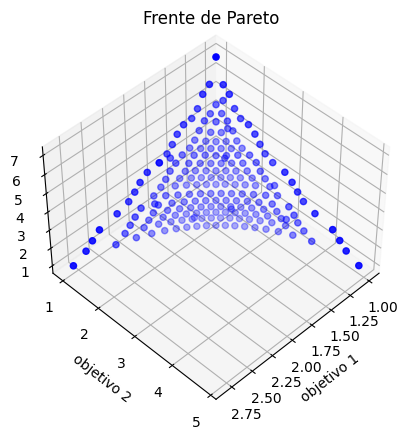

In [ ]:
# función principal 
def main(npop, iter, lb, ub, nobj=3, pc=1, pm=1, eta_c=30, eta_m=20):

    nvar = len(lb)  
    pop = np.random.uniform(lb, ub, (npop, nvar))  # ppop
    objs = cal_obj(pop, nobj)  
    V = puntos_ref(npop, nobj)  
    zmin = np.min(objs, axis=0)  
    [pfs, rank] = nd_sort(objs)  

    
    for t in range(iter):

        if (t + 1) % 10 == 0:
            print('Iteration: ' + str(t + 1) + ' completed.')

        
        sub_pop = selection(pop, pc, rank)
        off = cruza(sub_pop, lb, ub, pc, eta_c)
        off = muta(off, lb, ub, pm, eta_m)
        off_objs = cal_obj(off, nobj)

        zmin = np.min((zmin, np.min(off_objs, axis=0)), axis=0)
        pop, objs, rank = env_sel(np.concatenate((pop, off), axis=0), np.concatenate((objs, off_objs), axis=0), zmin, npop, V)

    pf = objs[rank == 0]
    ax = plt.figure().add_subplot(111, projection='3d')
    ax.view_init(45, 45)
    x = [o[0] for o in pf]
    y = [o[1] for o in pf]
    z = [o[2] for o in pf]
    ax.scatter(x, y, z, color='blue')
    ax.set_xlabel('objetivo 1')
    ax.set_ylabel('objetivo 2')
    ax.set_zlabel('objetivo 3')
    plt.title('Frente de Pareto')
    plt.savefig('frente_de_pareto')
    plt.show()

# problema WFG1 n=24, k=3 
wfg = WFG1(n_var=24, n_obj=3)

def cal_obj(pop, nobj):
    return wfg.evaluate(pop)

lb = np.zeros(24)
ub = np.ones(24)

main(npop=200, iter=500, lb=lb, ub=ub, nobj=3)